In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.plotting import scatter_matrix

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

In [4]:
listings2 = pd.read_csv("Data/airbnb/listings.csv")
calendar2 = pd.read_csv("Data/airbnb/calendar.csv")

In [5]:
listings = listings2.copy()
calendar = calendar2.copy()

#### In this notebook we will be looking at the Boston AirBnB data from the time period Sep 2016 - Sep 2017. The primary goal of our analysis is to try finding answers to the following business questions:
#### 1. What are the factors influencing the price?
#### 2. How do reviews influence the price?
#### 3. What areas are the most and least attractive?
#### 4. How does availability vary over the year?

##### The data we will use is (1) Listings, including full descriptions and average review score and (2) Calendar, including listing id and the price and availability for that day.

### First look at the data

In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [9]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [10]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


#### Note that the Listings dataset contains some columns that are not useful or that are mostly empty - we should remove those. Moreover, some columns like 'price' should be transformed from a string format with a special character to a numerical column. Finally, we should remove outliers! Hence, before we jump to building any sort of regression model, we should...

### Clean the data

#### In order to answer our business questions, we need to clean the data first: let's start with dropping the columns that are unlikely to help us. Those would be columns containing url information, id information or simply columns we don't expect to be a good predictor of the price.

In [11]:
# Drop columns that are unlikely to help us
drop_cols = ['id', 'listing_url', 'scrape_id',
             'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_about',
             'host_thumbnail_url', 'host_picture_url', 'last_scraped', 'calendar_last_scraped', 'first_review', 'last_review',
             'name','summary','space','transit','neighborhood_overview', 'access','interaction', 'is_location_exact',
             'weekly_price', 'monthly_price', 'description', 'host_location', 'host_neighbourhood', 'calendar_updated',
             'calculated_host_listings_count', 'host_listings_count']
listings.drop(drop_cols, axis=1, inplace =True)

#### Uff, it should be less cluttered now... Ok, now let's remove the columns for which more than 50% of the values is missing.

In [12]:
# First check if there is any columns we should drop due to lack of data
mean_miss = listings.apply(lambda col: col.isnull().mean(), axis = 0)
mean_miss.sort_values()

experiences_offered             0.000000
availability_30                 0.000000
smart_location                  0.000000
country_code                    0.000000
country                         0.000000
                                  ...   
square_feet                     0.984379
neighbourhood_group_cleansed    1.000000
has_availability                1.000000
license                         1.000000
jurisdiction_names              1.000000
Length: 63, dtype: float64

In [13]:
mean_miss[mean_miss > 0.5]

notes                           0.550907
neighbourhood_group_cleansed    1.000000
square_feet                     0.984379
security_deposit                0.625662
has_availability                1.000000
license                         1.000000
jurisdiction_names              1.000000
dtype: float64

#### We have 7 columns for which more than half data is not available - it's a good idea to remove those, apart from the security_deposit --> NA for that column can be simply replaced with a 0.

In [14]:
listings['security_deposit'] = listings['security_deposit'].fillna(0)

drop_cols = [col for col in mean_miss[mean_miss > 0.5].index if col != 'security_deposit' ]
listings.drop(drop_cols, axis = 1, inplace = True)

#### Now let's take care of the columns that should be numerical, but are classified as objects - those are 'price', 'host_acceptance_rate', 'cleaning_fee', 'extra_people' columns:

In [15]:
object_to_num_cols = ['price','host_acceptance_rate', 'host_response_rate', 'cleaning_fee', 'security_deposit','extra_people']
listings[object_to_num_cols].head()

,price,host_acceptance_rate,host_response_rate,cleaning_fee,security_deposit,extra_people
0,$250.00,NaN,NaN,$35.00,0,$0.00
1,$65.00,100%,100%,$10.00,$95.00,$0.00
2,$65.00,88%,100%,NaN,0,$20.00
3,$75.00,50%,100%,$50.00,$100.00,$25.00
4,$79.00,100%,100%,$15.00,0,$0.00


In [16]:
# All above columns need to be converted to a number.
# For price, cleaning_fee and extra_people we need to remove the $ sign and the',' characters and then cancel everything after the '.'
for col in ['price', 'cleaning_fee', 'security_deposit', 'extra_people']:
    listings[col] = listings[col].apply(lambda value: float(str(value).replace('$', '').replace(',', '').split('.')[0]))

# For host_acceptance_rate and host_response_rate remove the % sign
for col in ['host_acceptance_rate', 'host_response_rate']:
    listings[col] = listings[col].apply(lambda rate: float(str(rate).replace('%', '')))

listings[object_to_num_cols].head()


,price,host_acceptance_rate,host_response_rate,cleaning_fee,security_deposit,extra_people
0,250.0,NaN,NaN,35.0,0.0,0.0
1,65.0,100.0,100.0,10.0,95.0,0.0
2,65.0,88.0,100.0,NaN,0.0,20.0
3,75.0,50.0,100.0,50.0,100.0,25.0
4,79.0,100.0,100.0,15.0,0.0,0.0


#### As price is our dependent variable, let's make sure there is no illegitimate outliers in the data...

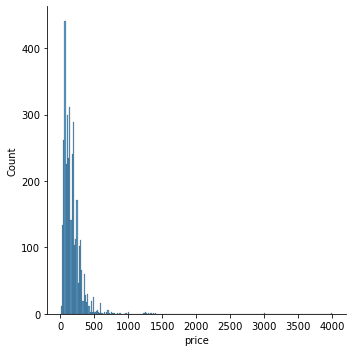

In [17]:
sns.displot(listings['price'])

In [18]:
listings['price'].sort_values()

2033      10.0
3468      11.0
471       20.0
3450      20.0
267       22.0
         ...  
1950    1345.0
2204    1372.0
793     1400.0
3055    3000.0
2285    4000.0
Name: price, Length: 3585, dtype: float64

#### The valuesof price <20 and >1400 look pretty weird - we should probably remove those...

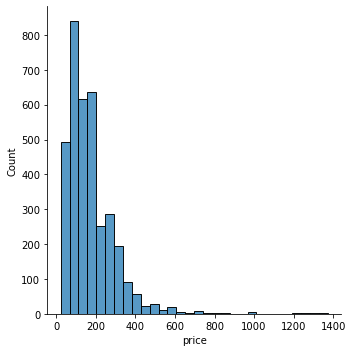

In [19]:
listings = listings[(listings['price']>20) & (listings['price']<1400)]
sns.displot(listings['price'], bins=30)

#### This is a bit better! Perfect, now let's now take care of the remaining missing values that we would like to impute, or which observations will be dropped. Firstly, let's use heatmap to visualize the number of missing values for the remaining columns.

<AxesSubplot:>

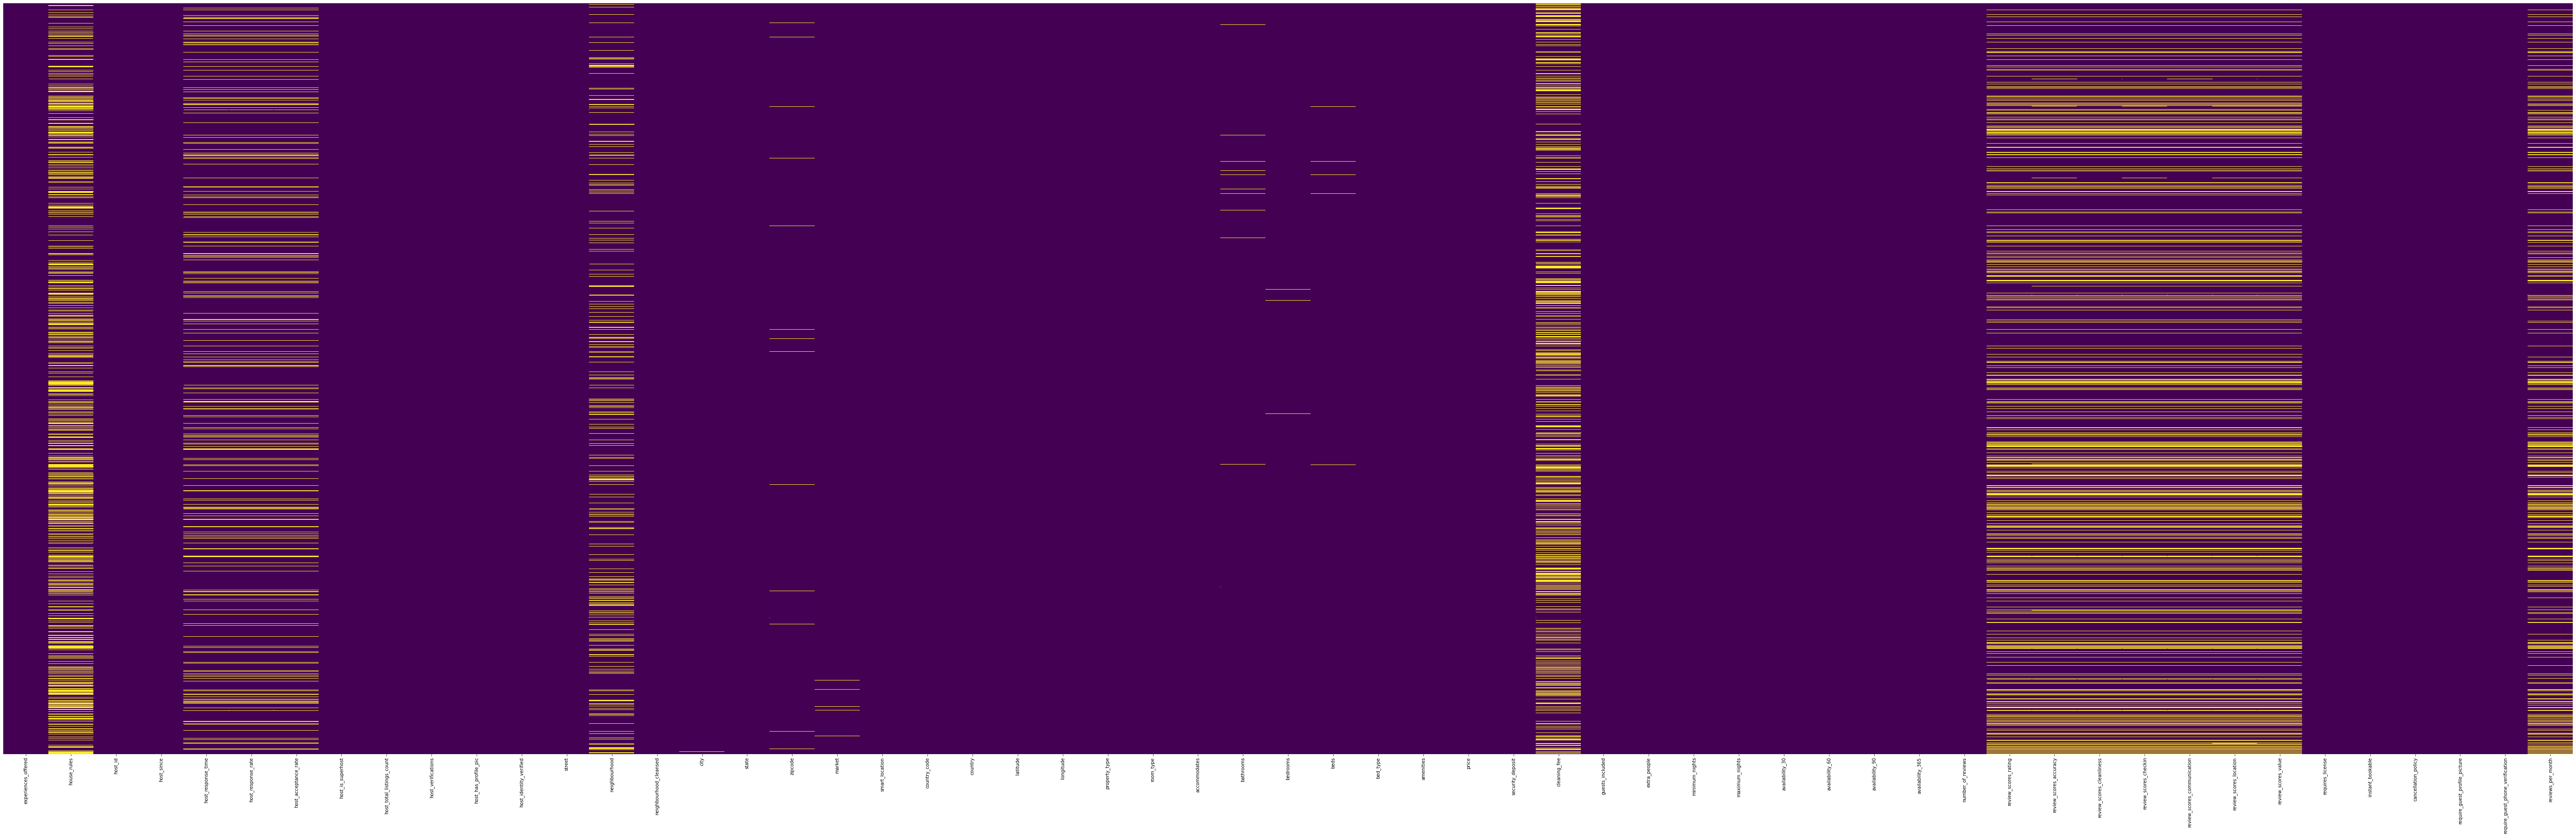

In [20]:
fig, ax = plt.subplots(figsize=(100,30))
sns.heatmap(ax = ax, data = listings.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [21]:
mean_miss = listings.apply(lambda col: col.isnull().mean(), axis = 0)
mean_miss[mean_miss > 0].sort_values(ascending = False)

house_rules                    0.332029
cleaning_fee                   0.307714
review_scores_accuracy         0.228619
review_scores_location         0.228340
review_scores_value            0.228060
review_scores_checkin          0.227781
review_scores_communication    0.227222
review_scores_cleanliness      0.227222
review_scores_rating           0.225824
reviews_per_month              0.209894
neighbourhood                  0.150922
host_acceptance_rate           0.130799
host_response_rate             0.130799
host_response_time             0.130799
zipcode                        0.010341
bathrooms                      0.003913
market                         0.003913
bedrooms                       0.002795
beds                           0.002515
property_type                  0.000838
city                           0.000559
dtype: float64

#### Let's start from the top

In [22]:
listings['house_rules'].head()

0    Clean up and treat the home the way you'd like...
1    Pet friendly but please confirm with me if the...
2    I encourage you to use my kitchen, cooking and...
3    - The bathroom and house are shared so please ...
4    Please no smoking in the house, porch or on th...
Name: house_rules, dtype: object

In [23]:
# House rules - some values are empty so create a column rules = 1 if present and 0 otherwise
print(sum(listings['house_rules'].isnull())/listings.shape[0])
listings['house_rules'] = [1 if rule == rule else 0 for rule in listings['house_rules']]

0.3320290665176076


In [24]:
listings['house_rules'].head()

0    1
1    1
2    1
3    1
4    1
Name: house_rules, dtype: int64

In [25]:
# Cleaning fee column same as security deposit - if missing set to 0
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)

<AxesSubplot:>

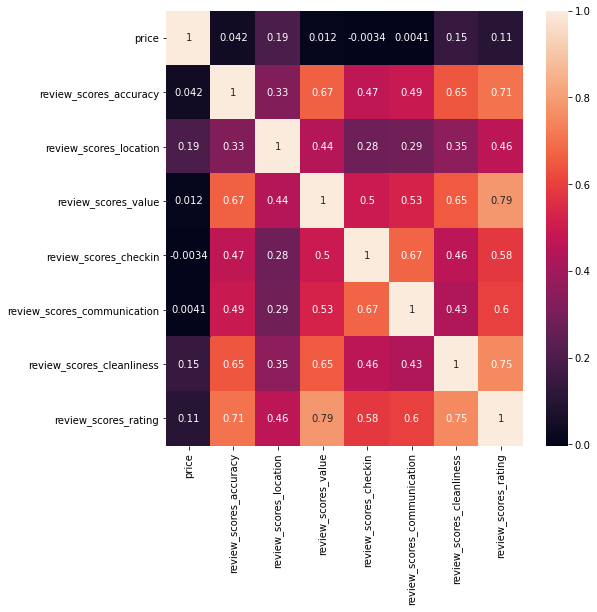

In [26]:
# For the reviews let's first see what values are correlated with the price the most
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(ax=ax, data=listings[['price', 'review_scores_accuracy', 'review_scores_location','review_scores_value', 'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness','review_scores_rating']].corr(), annot=True)

In [27]:
# Looks like the location and cleanlinness are the two ratings that matter the most - let's keep only those and 
# impute the missing values.

# First let's drop remaining ratings.
listings.drop(['review_scores_accuracy','review_scores_value', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating'], axis = 1, inplace = True)


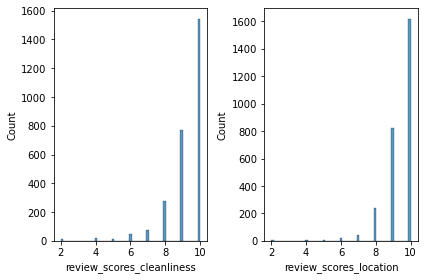

In [28]:
# Secondly, let's impute other missing scores - let's first look at their distribution
fig, ax = plt.subplots(1,2)
sns.histplot(listings['review_scores_cleanliness'], ax = ax[0])
sns.histplot(listings['review_scores_location'], ax = ax[1])
plt.tight_layout()

Avg cleanliness rating is 9.259312839059675
Avg location rating is 9.413618254255704


<AxesSubplot:ylabel='Count'>

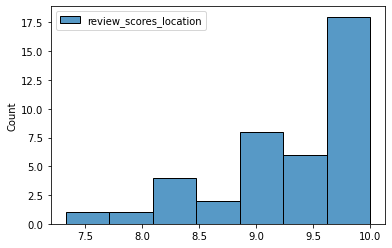

In [29]:
# Choosing a mode here would give each missing value a 10 - probably not a good idea. What is the mean?
print('Avg cleanliness rating is {0}'.format(listings['review_scores_cleanliness'].mean()))
print('Avg location rating is {0}'.format(listings['review_scores_location'].mean()))

# What is the mean per neighbourhood?
loc_ratings = listings.groupby('zipcode').mean()[['review_scores_location']].reset_index()
sns.histplot(loc_ratings)

In [30]:
# Ok, this is more reasonable - let's impute the means. Cleanliness is not dependent on the zipcode, but location yes.
# If the zipcode is missing, choose the main avg.

listings['review_scores_cleanliness'] = listings['review_scores_cleanliness'].fillna(listings['review_scores_cleanliness'].mean())

listings = listings.drop('review_scores_location', axis = 1).merge(loc_ratings, how = "left", on = "zipcode")
listings['review_scores_location'] = listings['review_scores_location'].fillna(listings['review_scores_location'].mean())


<AxesSubplot:xlabel='review_scores_location', ylabel='Count'>

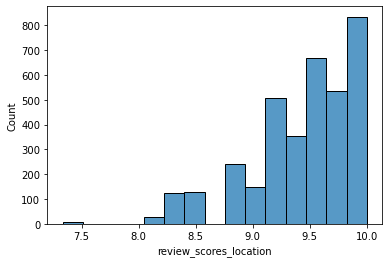

In [31]:
sns.histplot(listings['review_scores_location'], bins= 15)

In [32]:
# Impute missing reviews per month also 
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(listings['reviews_per_month'].mean())

In [33]:
# Host responsiveness - we have 3 columns 
listings[['host_acceptance_rate', 'host_response_rate', 'host_response_time']].head()

,host_acceptance_rate,host_response_rate,host_response_time
0,NaN,NaN,NaN
1,100.0,100.0,within an hour
2,88.0,100.0,within a few hours
3,50.0,100.0,within a few hours
4,100.0,100.0,within an hour


In [34]:
# Let's remove the host_response_time and fill in the averages for the rest
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].mean())
listings['host_response_rate'] = listings['host_response_rate'].fillna(listings['host_response_rate'].mean())
listings.drop('host_response_time', axis = 1, inplace = True)

In [35]:
# Now look at the columns with location data
listings['neighbourhood'].value_counts()

Allston-Brighton      363
Jamaica Plain         314
South End             298
Back Bay              291
Fenway/Kenmore        248
South Boston          215
Dorchester            195
Beacon Hill           174
North End             125
East Boston           117
Roxbury               115
Mission Hill          103
Charlestown            79
Chinatown              78
West End               68
Roslindale             50
West Roxbury           35
Theater District       33
Downtown Crossing      26
Hyde Park              25
Mattapan               20
Somerville             13
Financial District     13
Downtown                8
Brookline               8
Leather District        8
Cambridge               7
Chestnut Hill           4
Government Center       3
Harvard Square          2
Name: neighbourhood, dtype: int64

In [36]:
listings['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     289
Dorchester                 269
Allston                    258
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   171
East Boston                150
Roxbury                    143
North End                  143
Mission Hill               123
Charlestown                111
South Boston Waterfront     82
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Bay Village                 24
Mattapan                    24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

In [37]:
listings['market'].value_counts()

Boston                   3561
Other (International)       1
Other (Domestic)            1
San Francisco               1
Name: market, dtype: int64

In [38]:
listings['city'].value_counts()

Boston                       3375
Roxbury Crossing               23
Somerville                     19
Jamaica Plain                  18
Brookline                      18
Cambridge                      16
Dorchester                     15
Brighton                       15
Charlestown                    15
Allston                        12
Roslindale                      6
West Roxbury                    5
ROXBURY CROSSING                4
East Boston                     3
Mattapan                        3
Jamaica Plain, Boston           2
Jamaica Plain                   2
Boston, Massachusetts, US       2
ALLSTON                         2
South Boston                    2
Hyde Park                       2
Boston (Charlestown)            1
Newton                          1
Mission Hill, Boston            1
Milton                          1
波士顿                             1
Jamaica plain                   1
Brighton                        1
Roslindale, Boston              1
boston        

In [39]:
# The neighbourhood is the only value that is worth looking into but also note there is a column 
# neighbourhood_cleansed that we can use instead!
listings.drop(['zipcode', 'market', 'city', 'neighbourhood'], axis = 1, inplace = True)

In [40]:
#### For variables like bathrooms, bedrooms, beds there is very little missing values and at the same time
# we exepect those to be highly correlated with price. To keep those clean, let's simply remove the missing rows 

<AxesSubplot:>

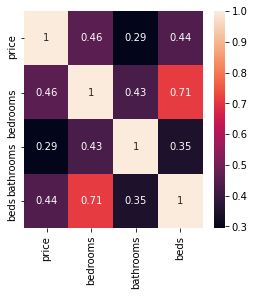

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(ax=ax, data=listings[['price', 'bedrooms', 'bathrooms','beds']].corr(), annot=True)

In [42]:
for col in ['bedrooms', 'bathrooms', 'beds']:
    listings.dropna(subset = [col], axis = 0, inplace = True)

In [43]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3550 entries, 0 to 3577
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   experiences_offered               3550 non-null   object 
 1   house_rules                       3550 non-null   int64  
 2   host_id                           3550 non-null   int64  
 3   host_since                        3550 non-null   object 
 4   host_response_rate                3550 non-null   float64
 5   host_acceptance_rate              3550 non-null   float64
 6   host_is_superhost                 3550 non-null   object 
 7   host_total_listings_count         3550 non-null   int64  
 8   host_verifications                3550 non-null   object 
 9   host_has_profile_pic              3550 non-null   object 
 10  host_identity_verified            3550 non-null   object 
 11  street                            3550 non-null   object 
 12  neighb

#### Great! No missing data left for the numerical variables. Let's look at the correlations of price to other variables and drop all that are not correlated to price.

In [44]:
num_corr = listings.corr()['price'].sort_values()
num_corr

host_acceptance_rate        -0.137050
reviews_per_month           -0.126513
number_of_reviews           -0.106457
host_id                     -0.065615
maximum_nights              -0.006374
host_response_rate          -0.005696
house_rules                  0.004275
extra_people                 0.022074
minimum_nights               0.022642
availability_365             0.046482
review_scores_cleanliness    0.114370
availability_90              0.123851
availability_60              0.141693
availability_30              0.162809
security_deposit             0.192297
longitude                    0.193797
host_total_listings_count    0.209602
latitude                     0.230625
guests_included              0.253299
bathrooms                    0.293735
review_scores_location       0.328944
cleaning_fee                 0.374348
beds                         0.440647
bedrooms                     0.459772
accommodates                 0.518619
price                        1.000000
Name: price,

In [45]:
# Drop everythings that has abs(corr) < 0.1
num_corr[abs(num_corr) < 0.1]

host_id              -0.065615
maximum_nights       -0.006374
host_response_rate   -0.005696
house_rules           0.004275
extra_people          0.022074
minimum_nights        0.022642
availability_365      0.046482
Name: price, dtype: float64

In [46]:
drop_cols = [col for col in num_corr[abs(num_corr) < 0.1].index]
listings.drop(drop_cols, axis = 1, inplace = True)

#### Great! Numerical variables done! Hence last step in the cleaning process is to deal with the categorical variables.

In [47]:
# Calc number of months since someone is a host
listings['host_since_num_months'] = pd.to_datetime(listings['host_since'])

import datetime
baseline_date = datetime.datetime(2018,1,1)
listings['host_since_num_months'] = (baseline_date - listings['host_since_num_months']) / np.timedelta64(1, 'M')

In [48]:
# Host flags
listings['host_has_profile_pic'] = [0 if flag == "f" else 1 for flag in listings['host_has_profile_pic']]
listings['host_is_superhost'] = [0 if flag == "f" else 1 for flag in listings['host_is_superhost']]
listings['host_identity_verified'] = [0 if flag == "f" else 1 for flag in listings['host_identity_verified']]
listings['instant_bookable'] = [0 if flag == "f" else 1 for flag in listings['instant_bookable']]

In [49]:
# Guest flags
listings['require_guest_profile_picture'] = [0 if flag == "f" else 1 for flag in listings['require_guest_profile_picture']]
listings['require_guest_phone_verification'] = [0 if flag == "f" else 1 for flag in listings['require_guest_phone_verification']]

In [50]:
# Check if those are at all correlated
num_corr = listings.corr()['price'].sort_values()
num_corr

host_acceptance_rate               -0.137050
reviews_per_month                  -0.126513
number_of_reviews                  -0.106457
instant_bookable                   -0.059520
require_guest_profile_picture      -0.015175
host_has_profile_pic                0.000373
host_is_superhost                   0.012612
host_identity_verified              0.026994
host_since_num_months               0.088565
review_scores_cleanliness           0.114370
availability_90                     0.123851
availability_60                     0.141693
availability_30                     0.162809
require_guest_phone_verification    0.164908
security_deposit                    0.192297
longitude                           0.193797
host_total_listings_count           0.209602
latitude                            0.230625
guests_included                     0.253299
bathrooms                           0.293735
review_scores_location              0.328944
cleaning_fee                        0.374348
beds      

In [51]:
num_corr[abs(num_corr) < 0.1]

instant_bookable                -0.059520
require_guest_profile_picture   -0.015175
host_has_profile_pic             0.000373
host_is_superhost                0.012612
host_identity_verified           0.026994
host_since_num_months            0.088565
Name: price, dtype: float64

In [52]:
drop_cols = [col for col in num_corr[abs(num_corr) < 0.1].index]
listings.drop(drop_cols, axis = 1, inplace = True)

In [53]:
listings['property_type'].value_counts()

Apartment          2586
House               555
Condominium         231
Townhouse            54
Loft                 39
Bed & Breakfast      39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

In [54]:
#Combine Dorm, Villa, ... under Other so that no bucket has less than 10 variables
listings['property_type'] = ['Other' if prop_type in ['Dorm', 'Villa', 'Guesthouse', 'Entire Floor', 'Camper/RV'] else prop_type for prop_type in listings['property_type']]
listings['property_type'].value_counts()

Apartment          2586
House               555
Condominium         231
Townhouse            54
Loft                 39
Bed & Breakfast      39
Other                31
Boat                 12
Name: property_type, dtype: int64

In [55]:
listings['room_type'].value_counts()

Entire home/apt    2110
Private room       1362
Shared room          78
Name: room_type, dtype: int64

In [56]:
listings['bed_type'].value_counts()

Real Bed         3418
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64

In [57]:
listings['cancellation_policy'].value_counts()

strict             1574
flexible            987
moderate            914
super_strict_30      75
Name: cancellation_policy, dtype: int64

In [58]:
# Create dummies
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''

    df_noncat = df[[col for col in df.columns if col not in cat_cols]]
    df_cat_dummies = pd.get_dummies(df[list(cat_cols)], dummy_na=dummy_na, drop_first=True)
    df = pd.concat([df_noncat, df_cat_dummies], axis=1)
    return df

In [61]:
#Non-cat columns
noncat_cols = list(listings.select_dtypes('number').columns)
cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'neighbourhood_cleansed']
all_cols = list(set(noncat_cols + cat_cols + ['price']))

df_reg = create_dummy_df(listings[all_cols], cat_cols, dummy_na = False)

In [62]:
df_reg.head()

,host_total_listings_count,longitude,accommodates,bathrooms,availability_60,cleaning_fee,reviews_per_month,bedrooms,price,guests_included,number_of_reviews,availability_30,review_scores_location,review_scores_cleanliness,beds,security_deposit,availability_90,host_acceptance_rate,latitude,require_guest_phone_verification,property_type_Bed & Breakfast,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury
0,1,-71.133068,4,1.5,0,35.0,1.971132,2.0,250.0,1,0,0,9.203390,9.259313,3.0,0.0,0,84.18328,42.282619,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,-71.134374,2,1.0,54,10.0,1.300000,1.0,65.0,0,36,26,9.203390,9.000000,1.0,95.0,84,100.00000,42.286241,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,-71.135765,2,1.0,46,0.0,0.470000,1.0,65.0,1,41,19,9.203390,9.000000,1.0,0.0,61,88.00000,42.292438,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,-71.121021,4,1.0,16,50.0,1.000000,1.0,75.0,2,1,6,9.427147,10.000000,2.0,100.0,26,50.00000,42.281106,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,-71.136258,2,1.5,34,15.0,2.250000,1.0,79.0,1,29,13,9.203390,10.000000,2.0,0.0,59,100.00000,42.284512,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Yay! We got our clean regression data... let's get to it!

### Linear regression

In [63]:
# Now can move on to the linear regression
X = df_reg.drop('price', axis = 1)
y = df_reg['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
lm = LinearRegression()
lm.fit(X_train,y_train)
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df.reset_index()

,index,Coefficient
0,host_total_listings_count,-0.045942
1,longitude,592.415921
2,accommodates,7.256953
3,bathrooms,31.788168
4,availability_60,0.399392
5,cleaning_fee,0.013585
6,reviews_per_month,-3.454972
7,bedrooms,41.401321
8,guests_included,2.583821
9,number_of_reviews,-0.121231


In [64]:
coeff_df.sort_values(by = 'Coefficient')

,Coefficient
latitude,-75.752893
room_type_Shared room,-62.453658
neighbourhood_cleansed_Dorchester,-61.750308
neighbourhood_cleansed_Mattapan,-55.583854
neighbourhood_cleansed_East Boston,-55.508428
room_type_Private room,-52.667586
neighbourhood_cleansed_Hyde Park,-40.863234
neighbourhood_cleansed_Roslindale,-32.220002
neighbourhood_cleansed_South Boston,-26.200907
neighbourhood_cleansed_West Roxbury,-23.954783


In [65]:
coeff_df.sort_values(by = 'Coefficient').transpose()

,latitude,room_type_Shared room,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_East Boston,room_type_Private room,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_West Roxbury,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_West End,cancellation_policy_strict,neighbourhood_cleansed_Roxbury,cancellation_policy_moderate,reviews_per_month,number_of_reviews,host_total_listings_count,neighbourhood_cleansed_Mission Hill,cleaning_fee,security_deposit,availability_90,host_acceptance_rate,availability_30,availability_60,property_type_Other,guests_included,property_type_Loft,beds,neighbourhood_cleansed_North End,property_type_House,property_type_Condominium,bed_type_Pull-out Sofa,review_scores_cleanliness,accommodates,neighbourhood_cleansed_Charlestown,property_type_Townhouse,bed_type_Futon,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Longwood Medical Area,bed_type_Couch,review_scores_location,neighbourhood_cleansed_Leather District,property_type_Bed & Breakfast,bed_type_Real Bed,neighbourhood_cleansed_Chinatown,require_guest_phone_verification,neighbourhood_cleansed_South End,bathrooms,property_type_Boat,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Bay Village,bedrooms,cancellation_policy_super_strict_30,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_Back Bay,longitude
Coefficient,-75.752893,-62.453658,-61.750308,-55.583854,-55.508428,-52.667586,-40.863234,-32.220002,-26.200907,-23.954783,-20.886183,-16.506909,-15.710085,-10.827378,-4.534989,-3.454972,-0.121231,-0.045942,0.009869,0.013585,0.033408,0.06137,0.277274,0.29624,0.399392,0.695782,2.583821,2.886313,3.223241,3.404224,3.61795,5.563082,6.091411,6.73745,7.256953,7.926289,8.037245,9.075772,10.057531,11.100666,14.878647,15.228982,15.881605,20.404859,21.421594,25.375277,25.681138,28.714745,31.788168,32.618358,36.45285,37.695736,38.44936,41.401321,41.75586,43.928834,51.987003,56.307479,592.415921


In [66]:
# Check how well the model performs
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.4605861942811842

### Nice job! Model explains almost half of the variation in the data!

In [69]:
calendar[calendar['available'] == 't'].head()

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00
367,3075044,2017-08-20,t,$65.00
368,3075044,2017-08-19,t,$75.00
369,3075044,2017-08-18,t,$75.00


In [70]:
calendar['available'].value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [71]:
calendar[~calendar.price.isna()]['available'].value_counts()

t    643037
Name: available, dtype: int64

In [72]:
calendar['date'].value_counts()

2016-09-19    3586
2017-05-19    3586
2016-11-25    3586
2017-01-13    3586
2016-11-29    3586
              ... 
2017-07-25    3586
2016-11-09    3586
2017-05-09    3586
2017-02-04    3586
2016-12-05    3586
Name: date, Length: 365, dtype: int64

In [73]:
avail_by_listing = calendar.loc[calendar['available'] == 't'].groupby(['listing_id']).count()['available'].reset_index()
avail_by_date = calendar.loc[calendar['available'] == 't'].groupby(['date']).count()['available'].reset_index()
avail_by_listing.head()

,listing_id,available
0,3353,249
1,5506,344
2,6695,324
3,6976,319
4,8792,248


In [74]:
avail_by_date.head()

,date,available
0,2016-09-06,570
1,2016-09-07,932
2,2016-09-08,999
3,2016-09-09,981
4,2016-09-10,956


In [75]:
avail_by_date['date'] = pd.to_datetime(avail_by_date['date'])
avail_by_date['date'][0].hour, avail_by_date['date'][0].month, avail_by_date['date'][0].day

avail_by_date['date_string'] = avail_by_date['date'].apply(lambda date: date.strftime("%d %b %Y"))
avail_by_date['week'] = avail_by_date['date'].apply(lambda date: str(date.isocalendar()[1]) + str(date.year))
avail_by_date.head(), avail_by_date.tail()

(        date  available  date_string    week
 0 2016-09-06        570  06 Sep 2016  362016
 1 2016-09-07        932  07 Sep 2016  362016
 2 2016-09-08        999  08 Sep 2016  362016
 3 2016-09-09        981  09 Sep 2016  362016
 4 2016-09-10        956  10 Sep 2016  362016,
           date  available  date_string    week
 360 2017-09-01       1795  01 Sep 2017  352017
 361 2017-09-02       1798  02 Sep 2017  352017
 362 2017-09-03       1802  03 Sep 2017  352017
 363 2017-09-04       1801  04 Sep 2017  362017
 364 2017-09-05       1801  05 Sep 2017  362017)

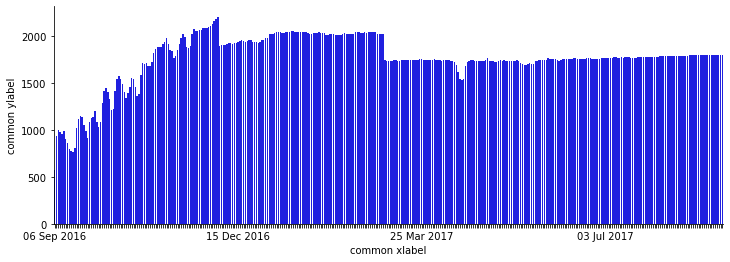

In [76]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x = 'date_string', y = 'available', data = avail_by_date, estimator=sum,color = 'blue')
sns.despine()
ax.set(xlabel='common xlabel', ylabel='common ylabel')

labels = ax.get_xticklabels()
#labels_dict = avail_by_date[['month', 'week']].unique()
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 100 == 0:  # every 10th label is kept
        label.set_visible(True)
        #ax.get_xticklabels()
        #lable[ind] = 
    else:
        label.set_visible(False)
#ax.legend(loc=0)

#labels = avail_by_date['date'][0].strftime("%d %b %Y")